<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment02/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##
Implementing following program from scratch

1. Convolution Function

2. Spatial Filtering with several kernel and discuss in which image case the kernel is suitable for

3. Sharpening with blurring operation

4. Make discussion in the end of COLAB, in which case the filtering should be used instead of pixel-based method.

Create your notebook with name as "PCD_Assignment02" and upload to GitHub. You need to provide your GitHub's code link to the text editor in submission form.

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 340 (delta 37), reused 5 (delta 2), pack-reused 200 (from 1)
Receiving objects: 100% (340/340), 10.00 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (106/106), done.
PCD  sample_data


##Image Acquire

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import statistics as st
import pdb
import copy

In [3]:
def Acquire(src,size):
  #Image and Copy
  img = plt.imread(src)
  img_copy = copy.deepcopy(img)

  #Plot Image dan Copy
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img)
  axs[0].set_title(f"Original, shape, {img.shape}")
  axs[1].imshow(img_copy)
  axs[1].set_title(f"Copy, shape {img_copy.shape}")
  plt.tight_layout()
  plt.show()

  return img, img_copy

##main

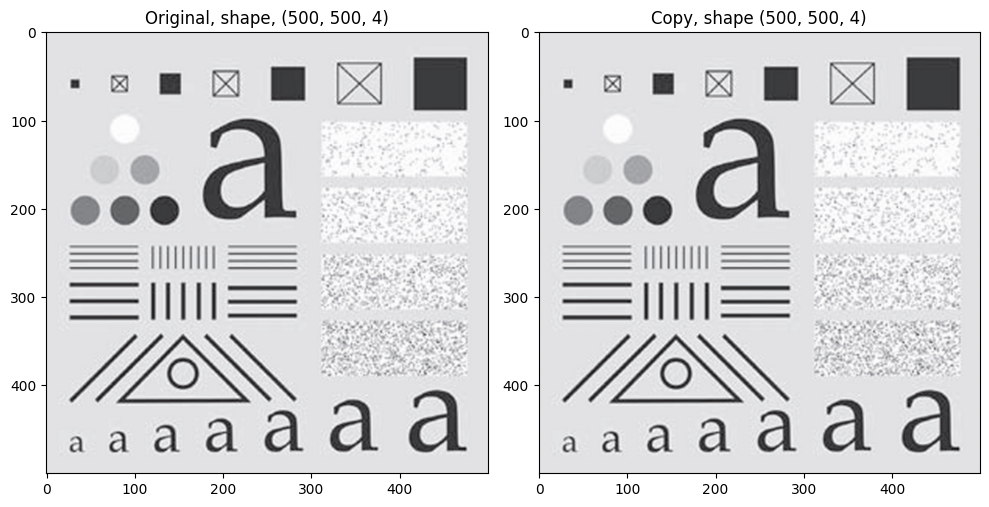

In [5]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/female01.png'
img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'

img,img_copy = Acquire(img_path,10)
# print(img[0][0],img_copy[-1][-1])

fungsi kernel

fungsi konvolusi

In [11]:
def func_convolution(img_,kernel):
  if img_copy.dtype != np.uint8:
    img_ = img_*255
    img_ = img_.astype(np.uint8)

  img_ = img_.astype(int)

  bgr = []
  if img_.shape[2] == 4:
    b,g,r,a = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)
    bgr.append(a)
  else:
    b,g,r = cv2.split(img_)
    bgr.append(b)
    bgr.append(g)
    bgr.append(r)

  bgr_pad = []
  for i in range(3):
    # bgr_pad = np.pad(b, pad_width=((1, 1), (1, 1)), mode='constant', constant_values=0)
    bgr_pad.append(np.pad(bgr[i], pad_width=1, mode='constant', constant_values=0))
    # print(bgr_pad)

  # img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(np.uint8)
  img_new = np.zeros((3,b.shape[0],b.shape[1])).astype(int)
  # print(img_new.shape)

  for h in range(3):
    for i in range(b.shape[0]):
      for j in range(b.shape[1]):
        img_new[h][i][j] = (kernel1[0][0]*bgr_pad[h][i][j]+kernel1[0][1]*bgr_pad[h][i][j+1]+kernel1[0][2]*bgr_pad[h][i][j+2])+(kernel1[1][0]*bgr_pad[h][i+1][j]+kernel1[1][1]*bgr_pad[h][i+1][j+1]+kernel1[1][2]*bgr_pad[h][i+1][j+2])+(kernel1[2][0]*bgr_pad[h][i+2][j]+kernel1[2][1]*bgr_pad[h][i+2][j+1]+kernel1[2][2]*bgr_pad[h][i+2][j+2])

  img_co = cv2.merge([img_new[0],img_new[1],img_new[2]])
  # img_co = cv2.merge([img_new[2],img_new[1],img_new[0]])
  img_co = img_co.astype(np.uint8)

  # plt.figure(figsize=(10, 10))
  plt.imshow(img_co)
  plt.show()

  return img_co

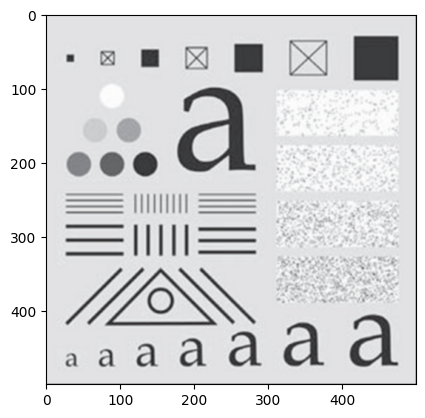

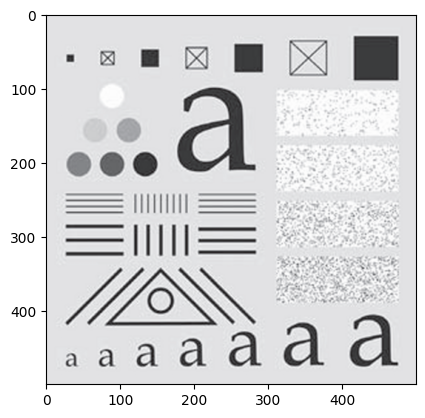

In [12]:
# kernel1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
# kernel1 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/16)
kernel1 = np.array([[1,2,1],[2,4,2],[1,2,1]])*(1/16)

output = func_convolution(img_copy,kernel1)
# plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [14]:
if img_copy.dtype != np.uint8:
  img_copy = img_copy*255
  img_copy = img_copy.astype(np.uint8)

img_copy = img_copy.astype(int)

bgr = []
if img_copy.shape[2] == 4:
  b,g,r,a = cv2.split(img_copy)
  bgr.append(b)
  bgr.append(g)
  bgr.append(r)
  bgr.append(a)
else:
  b,g,r = cv2.split(img_copy)
  bgr.append(b)
  bgr.append(g)
  bgr.append(r)

bgr_pad = []
for i in range(3):
  # bgr_pad = np.pad(b, pad_width=((1, 1), (1, 1)), mode='constant', constant_values=0)
  bgr_pad.append(np.pad(bgr[i], pad_width=5, mode='constant', constant_values=0))
  # print(bgr_pad)

print(bgr_pad)

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]
